# Plasma physics
By Alan Kaptanoglu, with some edits by Brian de Silva

This example is based off of the preprint found [here](https://arxiv.org/pdf/2004.10389.pdf)
and builds a data-driven dynamical system model for the temporal POD modes from an isothermal Hall-magnetohydrodynamic (Hall-MHD) plasma simulation of the HIT-SI experiment at the University of Washington.

This notebook shows off some advanced PySINDy features that were useful for this work:
1. Initial guesses to the SINDy optimization object
2. SR3 algorithm with linear equality constraints 
    (see [this preprint](https://arxiv.org/abs/1906.10612))
3. Matrix of thresholds, implemented only for ` ConstrainedSR3` for now 
    (although `ConstrainedSR3` can be used without using constraints and is then equivalent to `SR3`).

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import pysindy as ps

In [2]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, figsize=(12, 2 * n_rows), sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), label="Predicted (test)", **kws)
        ax.set(title="POD mode {}".format(i + 1))
        ax.legend(bbox_to_anchor=(0, -0.05), ncol=3, loc="upper left")

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

In [3]:
def plot_coefficients(coefficients, input_features=None, feature_names=None, ax=None, **heatmap_kws):
    """Plot learned coefficient matrix in human-readable way."""
    if input_features is None:
        input_features = [f"$\dot x_{k}$" for k in range(coefficients.shape[0])]
    else:
        input_features = [f"$\dot {fi}$" for fi in input_features]
    
    if feature_names is None:
        feature_names = [f"f{k}" for k in range(coefficients.shape[1])]

        
    with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}): 
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        
        max_mag = np.max(np.abs(coefficients))
        heatmap_args = {
            "xticklabels": input_features,
            "yticklabels": feature_names,
            "center": 0.0,
            "cmap": sns.color_palette("vlag", n_colors=20, as_cmap=True),
            "ax": ax,
            "linewidths": 0.1,
            "linecolor": "whitesmoke",
        }
        heatmap_args.update(**heatmap_kws)

        sns.heatmap(
            coefficients.T,
            **heatmap_args
        )

        ax.tick_params(axis="y", rotation=0)
    
    return ax

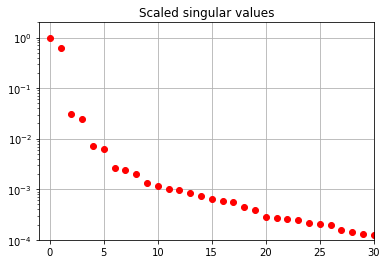

In [4]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("data/plasmaphysics_example_trajectories.txt")
t = A[:, 0]
A = A[:,1:]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

## Learning SINDy models for POD mode dynamics


### Unconstrained SR3 algorithm
Let's run a quadratic SINDy model on the first 7 POD modes using the unconstrainted SR3 algorithm with an initial guess.

In [5]:
r = 7
poly_order = 2
threshold = 0.05
tfrac = 0.8  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]

# Normalize the trajectories to the unit ball for simplicity
normalization = sum(np.amax(abs(A), axis=0)[1 : r + 1])
x = np.zeros((A.shape[0],r))
for i in range(r):
    x[:, i] = A[:, i] / normalization
    
# Build an initial guess
initial_guess = np.zeros((r,r + int(r * (r + 1) / 2)))
initial_guess[0, 1] = 0.091
initial_guess[1, 0] = -0.091
initial_guess[2, 3] = 0.182
initial_guess[3, 2] = -0.182
initial_guess[5, 4] = -3 * 0.091
initial_guess[4, 5] = 3 * 0.091

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

In [6]:
# We exclude the constant function from the library
sindy_library = ps.PolynomialLibrary(degree=poly_order, include_bias=False)

# SR3 optimizer with an initial guess
sindy_opt = ps.SR3(
    threshold=threshold, nu=1, initial_guess=initial_guess, max_iter=1000
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

# Fit a model on the training data
model.fit(x_train, t=t_train)
model.print()

a1' = 0.090 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


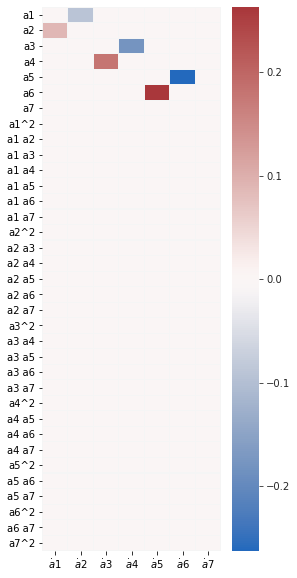

In [7]:
feature_names = model.get_feature_names()

fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [8]:
# Get Xdot from the measurement data X
x_dot = model.differentiate(x, t=t)

# Predict Xdot on the training and testing data. Since the model was trained on
# Xdot from the training data, x_dot_train is often in excellent agreement with x_dot.
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

print("Model score:", model.score(x, t=t))

Model score: 0.8315081674949204


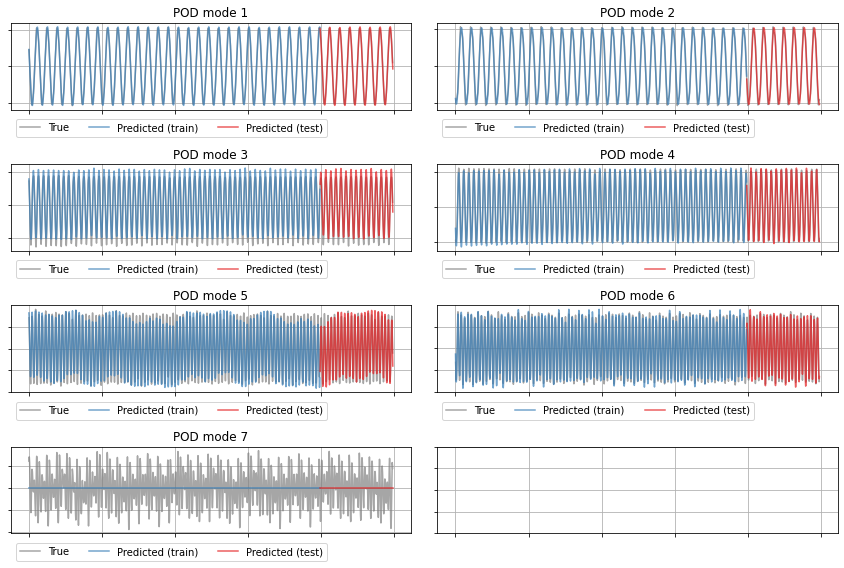

In [9]:
# Plot predicted derivatives
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

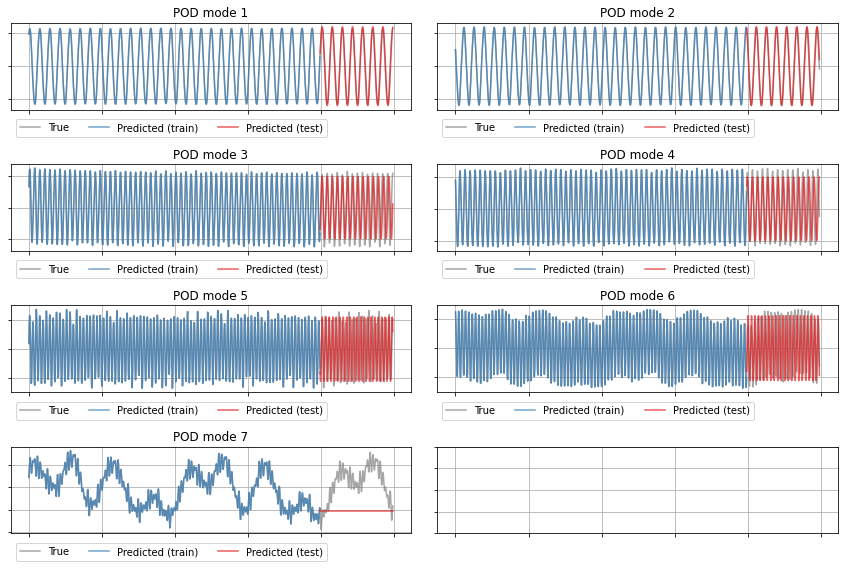

In [10]:
# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)

### Constrained SR3 algorithm
Now let's run a SINDy model on the first 7 modes using the constrainted SR3 algorithm with an initial guess. The constraint is that the linear part of the SINDy coefficient matrix must be anti-symmetric. Note in the resulting model, we have $\dot a_1 = 0.091a_2,\ \dot a_2 = -0.091a_1$, and so on.

This constraint is specific to the magnetohydrodynamics (MHD) model used for the provided simulation data.

In [11]:
threshold = 0.05
constraint_zeros = np.zeros(int(r * (r + 1) / 2))
constraint_matrix = np.zeros((int(r * (r + 1) / 2), int(r * (r ** 2 + 3 * r) / 2)))

# Define the constraint matrix
q = r
for i in range(r):
    constraint_matrix[i, i * (r + 1)] = 1.0
    counter = 1
    for j in range(i + 1, r):
        constraint_matrix[q, i * r + j] = 1.0
        constraint_matrix[q, i * r + j + counter * (r - 1)] = 1.0
        counter += 1
        q += 1

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=1,
    max_iter=10000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-6,
    initial_guess=initial_guess,
)

In [12]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.263 a6
a6' = -0.263 a5
a7' = 0.000


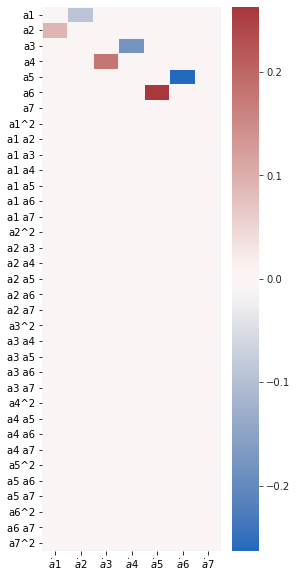

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [14]:
print("Model score:", model.score(x, t=t))

Model score: 0.8315075123206278


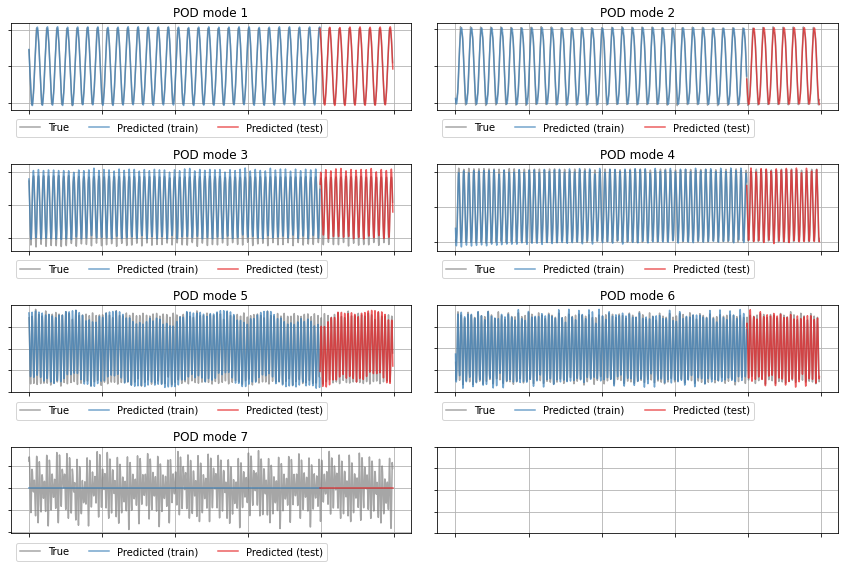

In [15]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

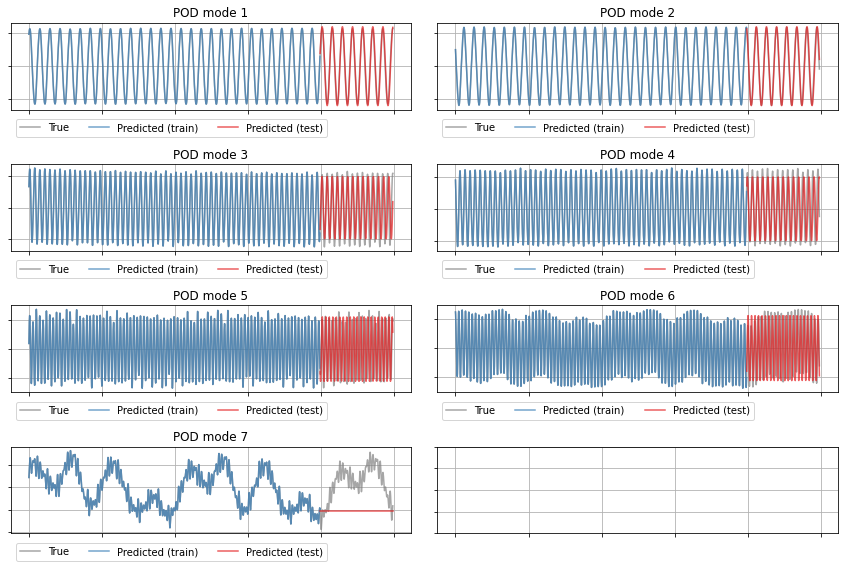

In [16]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, r)

### Constrained SR3 algorithm with term-dependent thresholding

Finally, we train a SINDy model on the first 7 modes using constrained SR3 with an initial guess *and* different thresholds for different library terms. We'll test out two sets of thresholds.

#### Encourage linear terms
We'll try get the model to emphasize linear terms by increasing thresholding on the quadratic terms.

In [17]:
threshold = 0.05

# Define a matrix of thresholds
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r, r + int(r * (r + 1) / 2)))

# Make the thresholds for the quadratic terms very large
thresholds[:, r:] = 30 * threshold

sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

In [18]:
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)
model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.179 a4
a4' = -0.179 a3
a5' = 0.262 a6 + -0.052 a7
a6' = -0.262 a5
a7' = 0.052 a5


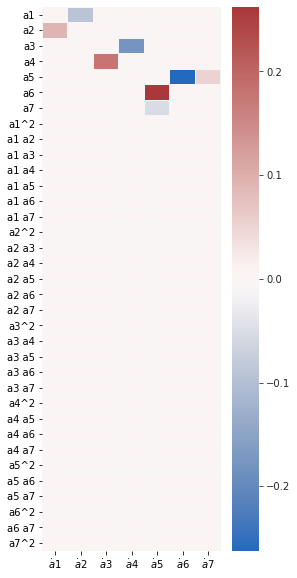

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [20]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)
print("Model score:", model.score(x, t=t))

Model score: 0.875402457830791


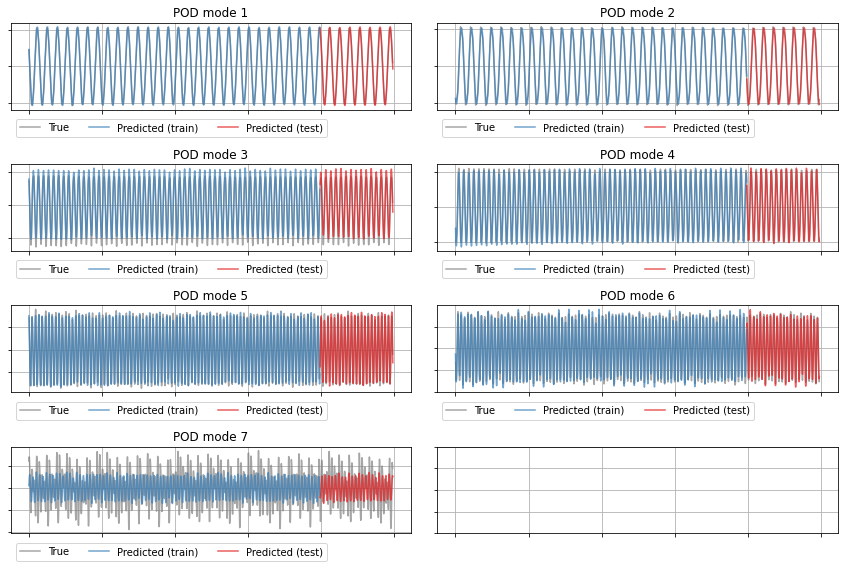

In [21]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

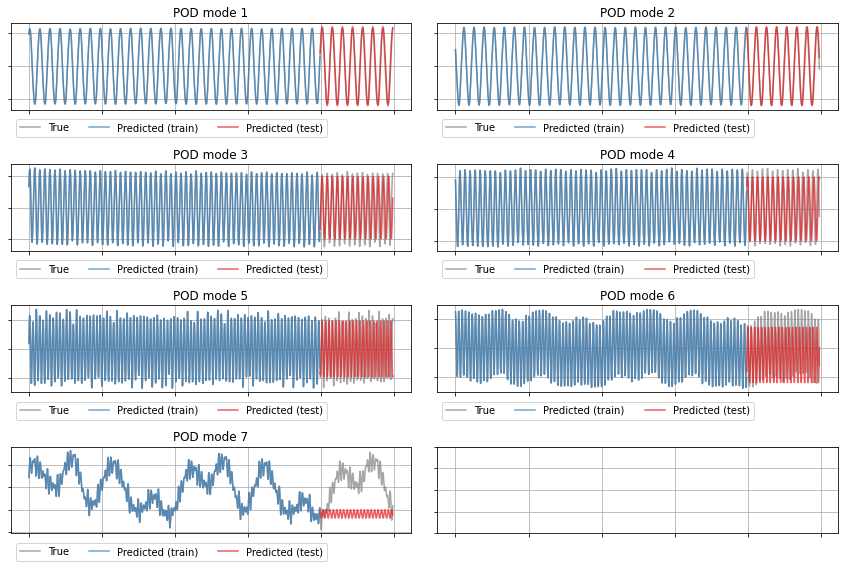

In [22]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, n_modes=r)

#### Allow some quadratic terms

The linear terms look pretty good but there are still some small errors in the frequencies
and they can't seem to capture the 7th mode. Let's demand quadratic models for a3-a7. Although 
we can mess around with these thresholds for better performance, there is a limit
to the progress we can make with this set of modes -- modes 1-6 are close to monochromatic
which will make it difficult to capture frequency dependence beyond the driving frequency
and its harmonics.

In [23]:
threshold = 0.05
thresholder = "weighted_l0"
thresholds = threshold * np.ones((r, r + int(r * (r + 1) / 2)))

# Try complicated set of thresholding (try playing around with these)
thresholds[0:2, r:] = 30 * threshold
thresholds[2, r:] = 0.2
thresholds[3, r:] = 0.05
thresholds[4:6, r:] = 0.03

In [24]:
sindy_opt = ps.ConstrainedSR3(
    threshold=threshold,
    nu=10,
    max_iter=50000,
    constraint_lhs=constraint_matrix,
    constraint_rhs=constraint_zeros,
    constraint_order="feature",
    tol=1e-5,
    thresholder=thresholder,
    initial_guess=initial_guess,
    thresholds=thresholds,
)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
    feature_names=pod_names,
)

model.fit(x_train, t=t_train)
model.print()

a1' = 0.091 a2
a2' = -0.091 a1
a3' = 0.180 a4
a4' = -0.180 a3 + -0.203 a1 a6 + -0.204 a2 a5 + -0.095 a3 a4
a5' = 0.263 a6 + -0.053 a7 + -0.116 a2 a5 + 0.115 a3 a5 + 0.172 a3 a7 + -0.082 a4 a6
a6' = -0.263 a5 + -0.089 a4 a6 + -0.249 a4 a7
a7' = 0.053 a5 + 0.205 a1 a5 + 0.263 a1 a6 + 0.213 a2 a5 + -0.133 a2 a6 + 0.317 a3^2 + 0.488 a3 a4 + -0.352 a4^2 + 0.145 a4 a6


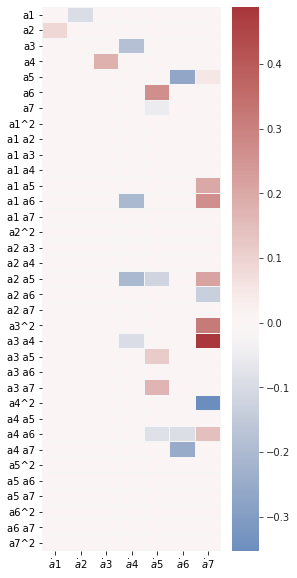

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10))
plot_coefficients(model.coefficients(), input_features=pod_names, feature_names=feature_names, ax=ax);

In [26]:
print("Model score:", model.score(x, t=t))

Model score: 0.9753455175443859


In [27]:
x_dot = model.differentiate(x, t=t)
x_dot_train = model.predict(x_train)
x_dot_sim = model.predict(x_test)

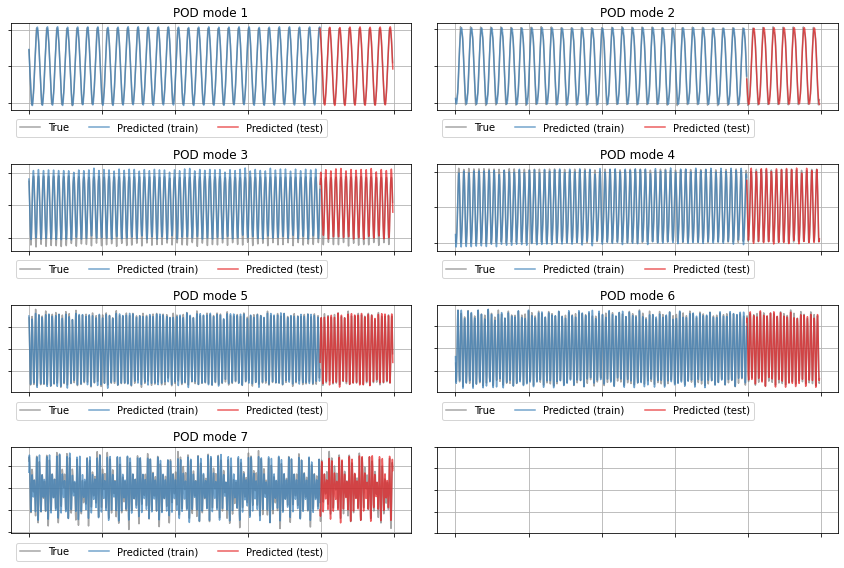

In [28]:
plot_trajectories(x_dot, x_dot_train, x_dot_sim, n_modes=r)

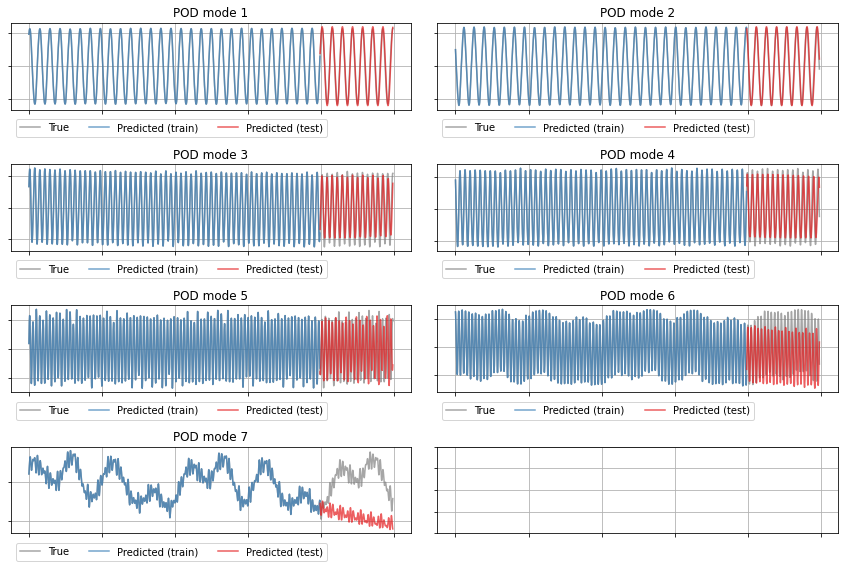

In [29]:
x_sim = model.simulate(x0_test, t_test)
plot_trajectories(x, x_train, x_sim, n_modes=r)